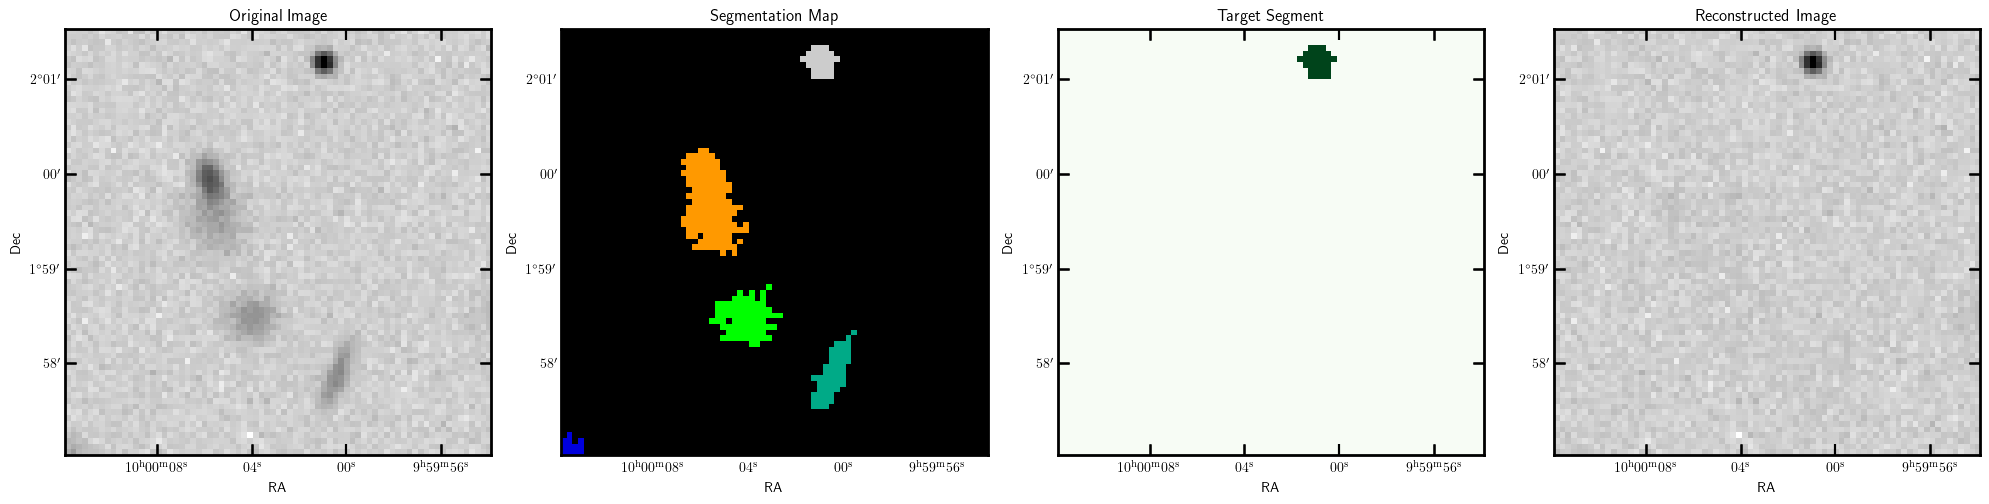

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from photutils.background import Background2D, MedianBackground, SExtractorBackground
from photutils.segmentation import SourceCatalog, SegmentationImage
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from photutils.segmentation import detect_threshold

# NFFT for Fourier Transforms
import nfft

# Astropy Cosmology
from astropy.cosmology import Planck18, FlatLambdaCDM

# Plotting configuration
mpl.rcParams.update({
    'text.usetex': True,
    'xtick.major.size': 8,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.3,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.3,
    'patch.linewidth': 1.3,
    'axes.linewidth': 2
})

# Set environment variables
os.environ["OMP_NUM_THREADS"] = "1"

# Display settings for Jupyter Notebooks
display(HTML("<style>.container { width:100% !important; }</style>"))

# Add custom module paths
sys.path.insert(1, '../../milestone2/bispec_phase/scripts/notebooks/')



def galaxy_segmentation(image, wcs, target_ra, target_dec, threshold=3.0, npixels=5):
    """
    Segment galaxies in an image and identify the segment corresponding to a target galaxy.
    """
    # Detect threshold and create a segmentation map
    threshold_value = detect_threshold(image, nsigma=threshold)
    segment_map = detect_sources(image, threshold=np.nanmean(threshold_value), npixels=npixels)

    if segment_map is None:
        raise ValueError("No sources were detected in the image.")

    # Create a source catalog for detected segments
    catalog = SourceCatalog(data=image, segment_img=segment_map)

    # Target galaxy coordinates
    target_coord = SkyCoord(ra=target_ra, dec=target_dec, unit="deg")

    # Variables to store the best match
    min_separation = float("inf")
    target_segment_id = None

    # Find the segment with the shortest separation to the target
    for idx, segment in enumerate(catalog):
        # Get the centroid in pixel coordinates
        segment_centroid_pixel = segment.centroid

        # Convert pixel centroid to sky coordinates
        segment_centroid_sky = wcs.pixel_to_world(segment_centroid_pixel[0], segment_centroid_pixel[1])

        # Calculate separation
        separation = segment_centroid_sky.separation(target_coord).arcsecond

        # Update the best match if a smaller separation is found
        if separation < min_separation:
            min_separation = separation
            target_segment_id = idx + 1  # Segmentation labels are 1-based

    # Extract the target segment mask if found
    if target_segment_id is not None:
        target_mask = segment_map.data == target_segment_id
    else:
        target_mask = None

    return {
        "entire_image": image,
        "entire_segments": segment_map.data,
        "target_segment": target_mask,
    }


def process_segmented_image(image, segment_map, target_mask):
    """
    Process a segmented image to extract the target source and reconstruct the background.
    """
    # Task 1: Extract the target source image
    target_image = np.zeros_like(image)
    if target_mask is not None:
        target_image[target_mask] = image[target_mask]

    # Task 2: Mask all segments and fill them with noise
    all_segments_mask = segment_map > 0  # Mask for all segments
    background_mask = ~all_segments_mask  # Mask for background (no segments)

    # Estimate noise from the background
    background_pixels = image[background_mask]
    noise_mean = np.mean(background_pixels)
    noise_std = np.std(background_pixels)

    # Generate a noise-filled image
    noise_filled_image = image.copy()
    random_noise = np.random.normal(loc=noise_mean, scale=noise_std, size=image.shape)
    noise_filled_image[all_segments_mask] = random_noise[all_segments_mask]

    # Reconstruct the image with the target source and noise-filled segments
    reconstructed_image = noise_filled_image.copy()
    if target_mask is not None:
        reconstructed_image[target_mask] = image[target_mask]  # Restore the target source

    return {
        "target_image": target_image,
        "noise_filled_image": noise_filled_image,
        "reconstructed_image": reconstructed_image,
    }


if __name__ == "__main__":
    # Create sample data
    data = make_100gaussians_image()[100:175, 100:175]

    # Example WCS
    wcs = WCS(naxis=2)
    wcs.wcs.crpix = [50, 50]
    wcs.wcs.cdelt = [-0.001, 0.001]
    wcs.wcs.crval = [150.0, 2.0]
    wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]

    # Define target galaxy RA and Dec
    RA_gal, Dec_gal = (10 * u.hourangle + 6 * u.arcsecond).to(u.deg), 2 * u.deg

    # Segment galaxies and find the target
    segmentation_result = galaxy_segmentation(
        image=data, wcs=wcs, target_ra=RA_gal, target_dec=Dec_gal, threshold=2.0, npixels=10
    )

    # Process the segmented image
    result = process_segmented_image(
        image=segmentation_result["entire_image"],
        segment_map=segmentation_result["entire_segments"],
        target_mask=segmentation_result["target_segment"],
    )

    # Plot results
    norm = simple_norm(data, "sqrt")

    fig, axes = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={"projection": wcs})

    # Original Image
    axes[0].imshow(data, origin="lower", cmap="Greys", norm=norm)
    axes[0].set_title("Original Image")
    axes[0].set_xlabel("RA")
    axes[0].set_ylabel("Dec")

    # Segmentation Map
    axes[1].imshow(segmentation_result["entire_segments"], origin="lower", cmap="nipy_spectral")
    axes[1].set_title("Segmentation Map")
    axes[1].set_xlabel("RA")
    axes[1].set_ylabel("Dec")

    # Target Segment
    if segmentation_result["target_segment"] is not None:
        axes[2].imshow(segmentation_result["target_segment"], origin="lower", cmap="Greens")
        axes[2].set_title("Target Segment")
    else:
        axes[2].text(0.5, 0.5, "No Target Found", ha="center", va="center")
        axes[2].set_title("Target Segment")
    axes[2].set_xlabel("RA")
    axes[2].set_ylabel("Dec")

    # Reconstructed Image
    axes[3].imshow(result["reconstructed_image"], origin="lower", cmap="Greys", norm=norm)
    axes[3].set_title("Reconstructed Image")
    axes[3].set_xlabel("RA")
    axes[3].set_ylabel("Dec")

    plt.tight_layout()
    plt.show()
